<a href="https://colab.research.google.com/github/karsarobert/MachineLearning2025/blob/main/PTE_ML8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A mesterséges intelligencia matematikai alapjai gyakorlat
# PTE Gépi tanulás

## 8. Gyakorlat: Döntési fák, véletlen erdők, boosting, gridsearch
### 2025. november 3.

# Hiperparaméterek hangolása gridsearch segítségével

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv('https://raw.githubusercontent.com/karsarobert/MachineLearning2025/main/diabetes.csv') # adatok betöltése

y = df.label #X,y beállítása
X= df.drop(['label'], axis = 1)


In [ ]:
df

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


| Magyar | Angol | Jelentés | Típus |
|---|---|---|---|
| Terhes | Pregnancies | Terhesség ideje (hónapokban) | Szám |
| Vércukor | Glucose | Vércukor 2 órás OGTT vizsgálat után (mg/dL) | Szám |
| Vérnyomás | BloodPressure | Diastolés vérnyomás (Hgmm) | Szám |
| Triceps bőrredő vastagság | SkinThickness | Triceps bőrredő vastagsága (mm) | Szám |
| Testtömeg-index | BMI | Testtömeg-index (kg/m^2) | Szám |
| Családi kórtörténet | DiabetesPedigreeFunction | Családban előforduló cukorbetegség (0=nincs, 1=van) | Kategória |
| Életkor | Age | Életkor (években) | Szám |
| Inzulin | Insulin | 2 órás OGTT vizsgálat során mért inzulin koncentráció (µU/mL) | Szám |
| C-peptid | Cpeptide | 2 órás OGTT vizsgálat során mért C-peptid koncentráció (ng/mL) | Szám |
| Cukorbetegség | Outcome | Cukorbetegség diagnózisa (0=nem, 1=igen) | Kategória |

# Keresztvalidáció (Cross-Validation)

A **keresztvalidáció** (*cross-validation*) egy **modellértékelési technika**, amelyet arra használunk, hogy megbízhatóan felmérjük egy gépi tanulási modell **általánosító képességét**.
Segít annak elkerülésében, hogy a modell **túltanuljon** az adatokra, és torz becslést adjon a teljesítményéről.

---

## Hogyan működik?

1. Az adathalmazt **K egyenlő részre (foldra)** osztjuk.

   * Például: ha K = 5, akkor 5 részre bontjuk az adatokat.
2. A modell **K-szor** kerül betanításra:

   * Minden iterációban egy rész (fold) lesz a **validációs halmaz**,
   * A többi ( K-1 ) rész pedig a **tanítóhalmaz**.
3. Minden körben kiszámítjuk a modell teljesítményét (pl. pontosság, R², F1-score stb.).
4. Az iterációk végén a teljesítményeket **átlagoljuk**, így kapunk egy megbízható, stabil értéket:

$$
\text{Performance} = \frac{1}{K} \sum_{i=1}^{K} \text{Performance}_i
$$

## Miért hasznos?

*  **Megbízhatóbb teljesítménybecslés**: nem függ attól, hogy hogyan osztottuk az adatokat egyszer.
*  **Jobban használja az adatokat**: minden minta szerepel tanító- és validációs halmazban is.
*  **Túlilleszkedés detektálása**: segít észrevenni, ha a modell csak a tanítóhalmazon teljesít jól.
*  **Kis adathalmazoknál különösen előnyös**.




![](https://miro.medium.com/max/1400/0*W7JGxNLP1Jvlz3Hu.png)



In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Adatok betöltése
X, y = load_iris(return_X_y=True)

# Modell definiálása
model = RandomForestClassifier(random_state=42)

# KFold beállítása (5 részre)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Keresztvalidáció futtatása
scores = cross_val_score(model, X, y, cv=kf)

print("Egyes foldok pontossága:", scores)
print("Átlagos pontosság:", scores.mean())

Egyes foldok pontossága: [1.         0.96666667 0.93333333 0.93333333 0.96666667]
Átlagos pontosság: 0.9600000000000002


# Grid Search – Hiperparaméter optimalizálás

A **Grid Search** egy **hiperparaméter-keresési technika**, amely a megadott paraméterértékek **rácsát (gridjét)** végigpróbálva megkeresi a modellhez legjobban illeszkedő beállításokat.
A cél, hogy megtaláljuk azt a paraméterkombinációt, amely **a legjobb teljesítményt** adja a validációs adatokon (pl. pontosság, F1-score, RMSE stb.).


![](https://i0.wp.com/sqlrelease.com/wp-content/uploads/2021/08/An-introduction-to-GridSearchCV-and-RandomizedSearchCV-Image.jpg?w=954&ssl=1)

## Hogyan működik?

1. **Paraméterrács (grid) definiálása**

   * Kiválasztunk néhány paramétert, pl. `learning_rate`, `max_depth`, `n_estimators`, stb.
   * Megadjuk mindegyikhez a kipróbálandó értékeket.
   * Ezekből minden **lehetséges kombináció** létrejön.

2. **Modell tanítása minden kombinációval**

   * Minden paraméterkombinációra a modell újratanul.
   * A teljesítményt (score) jellemzően **keresztvalidációval (cross-validation)** mérjük.

3. **Teljesítményértékelés**

   * Az összes kipróbált kombinációhoz rögzítjük a teljesítményt.
   * A legjobb átlagos eredményt adó beállítás lesz a **legjobb modell**.

## Az ábra értelmezése

* A két tengely a **két vizsgált hiperparamétert** mutatja:

  * X-tengely → *Hyperparameter 1*
  * Y-tengely → *Hyperparameter 2*
* Minden cella (kék négyzet) egy-egy kombinációt jelöl, és benne a modell teljesítménye (score) látható.
* A **sárga cella** kiemeli az optimális paraméterkombinációt — ez adta a **legjobb eredményt** (itt: 0.171).

*A Grid Search tehát szisztematikusan „átpásztázza” a paraméterteret, és megtalálja az optimális modellt.*

## Miért hasznos a Grid Search?

* **Automatizált keresés** – nem kell manuálisan próbálgatni a beállításokat
* **Keresztvalidációval kombinálva** megbízható teljesítménybecslést ad
* **Rendszeres módszer**: biztos, hogy megtalálja a legjobb kombinációt a vizsgált tartományban
* **Bármilyen modellt** támogat, amely paraméterezhető (pl. SVM, Random Forest, XGBoost)

---

## Hátrányok

* **Időigényes** – minden kombinációhoz külön modell tanítás szükséges
* **Nem skálázható jól**, ha sok hiperparamétert vagy széles értéktartományokat adunk meg

Alternatíva: **RandomizedSearchCV**, amely véletlenszerű kombinációkat próbál ki gyorsabban.

---

## Összefoglalás

| Fogalom         | Jelentés                                                             |
| --------------- | -------------------------------------------------------------------- |
| **Grid Search** | Hiperparaméter-rács teljes átvizsgálása                              |
| **Cél**         | A legjobb paraméterkombináció megtalálása                            |
| **Értékelés**   | Keresztvalidációs pontosság alapján                                  |
| **Előny**       | Garantáltan megtalálja a legjobb kombinációt a vizsgált tartományban |
| **Hátrány**     | Lassú, számításigényes                                               |
| **Alternatíva** | Randomized Search, Bayesian Optimization                             |


In [ ]:
from sklearn.model_selection import GridSearchCV # paraméterek hangolása
rf_clf = DecisionTreeClassifier() # a döntési fa osztályozó
params_grid = {"max_depth" : [3,4,5,6,7,8,9,10, None],
              "min_samples_split": [2, 3, 10, 20], # a min_samples_split paraméter azt határozza meg, hogy egy belső csomópontot (node) legalább hány minta esetén oszt fel a döntési fa
              } # döntési fához tartozó hiperparaméterek felsorolása egy dictionary be
grid_search = GridSearchCV(rf_clf, params_grid,
                           n_jobs=-1, cv=5, scoring='accuracy') #grid search beállítása, n_jobs paraméter azt határozza meg, hogy a grid search futtatása során hány párhuzamos folyamat (CPU mag) legyen használva. Ha -1-et adunk meg, akkor a rendszer az összes elérhető processzormagot kihasználja
grid_search.fit(X, y) #illesztés

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None],
                         'min_samples_split': [2, 3, 10, 20]},
             scoring='accuracy')

In [ ]:
grid_search.best_params_ # a megadott paraméterekből a legjobb találat

{'max_depth': 5, 'min_samples_split': 2}

In [ ]:
from sklearn.metrics import accuracy_score
cvrf_clf = grid_search.best_estimator_ # a legjobb modell kiválasztása
grid_search.best_score_ # a legjobb modell pontossága

np.float64(0.7513878278584161)

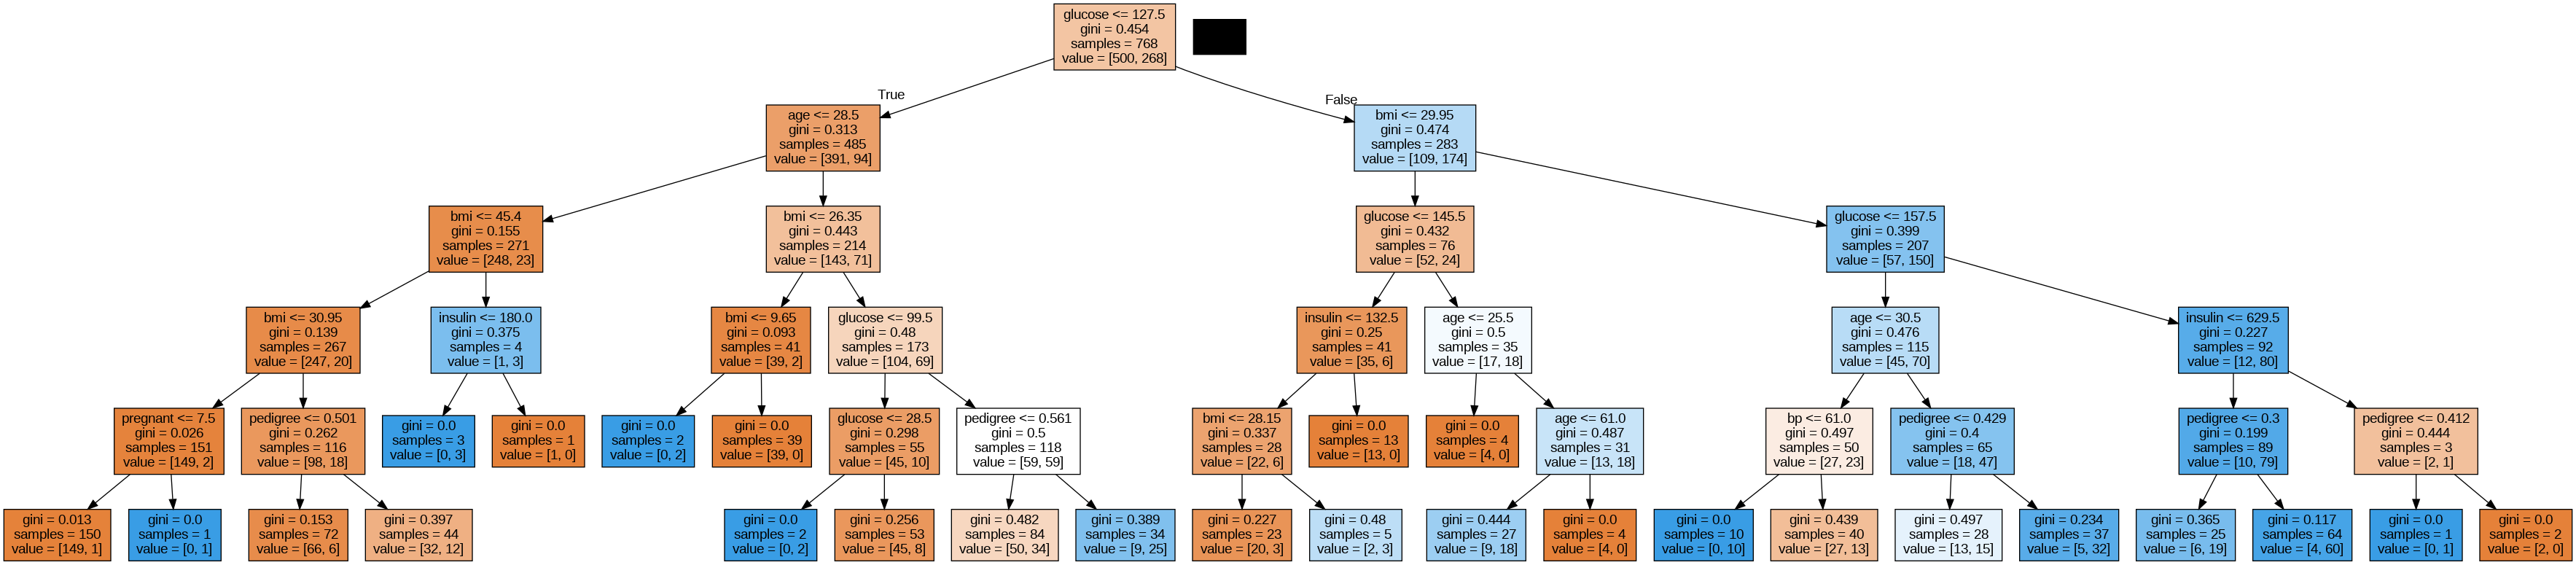

In [ ]:
from sklearn import tree
import pydotplus
from IPython.display import Image

dot_data = tree.export_graphviz(cvrf_clf, out_file=None,feature_names= X.columns, filled = True) # a legjobb modell ábrázolása
graph2 = pydotplus.graph_from_dot_data(dot_data)
Image(graph2.create_png())

# Ensemble (Együttes) módszerek

Az **ensemble learning** (együttes tanulás) olyan gépi tanulási megközelítés, amely **több, egymástól független modell** előrejelzését **kombinálja** annak érdekében, hogy **jobb teljesítményt és általánosítást** érjen el, mint bármelyik egyedi modell önmagában.

---

## Az ensemble tanulás alapötlete

1. **Több modell** tanítása ugyanazon tanítóhalmazon (vagy annak különböző részein).
   Ezeket nevezzük **alapmodelleknek** (*base learners*):

   * például $ C_1, C_2, ..., C_m $
2. Minden modell önálló **előrejelzést** készít ($ P_1, P_2, ..., P_m $).
3. Az előrejelzéseket egy **összevonási szabály** (*aggregation rule*) kombinálja,
   például **többségi szavazással** (classification) vagy **átlagolással** (regression).

Az eredmény egy **végső előrejelzés** $ P_f $, ami tipikusan **pontosabb** és **stabilabb**, mint az egyes komponensek.

## Majority Voting – Többségi szavazás

A **majority voting** az ensemble módszerek legegyszerűbb és leggyakoribb típusa:

* Minden modell szavaz egy osztálycímkére (pl. *A*, *B*, *C*).
* A végső döntés az lesz, amelyik **legtöbb szavazatot** kapta.

$
P_f = \text{argmax}_k \sum_{i=1}^{m} I(P_i = k)
$

ahol

* $ I(P_i = k) = 1 $, ha az $ i $-edik modell az $ k $-adik osztályt választotta,
* $ m $ a modellek száma,
* $ k $ pedig a lehetséges osztálycímkék indexe.

📊 *Az ábrán a különböző modellek (C₁, C₂, …, Cₘ) előrejelzéseit (P₁, P₂, …, Pₘ) a voting réteg egyesíti a végső kimenetté (P_f).*


![](https://www.researchgate.net/publication/324014302/figure/fig2/AS:644424015040514@1530654066950/Majority-voting-algorithm.png)

In [ ]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import VotingClassifier # többségi szavazás
from sklearn.linear_model import LogisticRegression

import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/karsarobert/MachineLearning2025/main/diabetes.csv") # adatok betöltése

y = df.label #X,y beállítása
X = df.drop(['label'], axis = 1)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=1) # első felosztás train, teszt halmazokra

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=1) # második felosztás a train halmazt tovább osztjuk train és valid halmazokra

print('Train/Valid/Test sizes:', y_train.shape[0], y_val.shape[0], y_test.shape[0]) # az egyes halmazok elemszámainak kiiratása

# definiálunk 3 osztályozót
clf1 = DecisionTreeClassifier(random_state=1, max_depth=None)
# max_depth=None a csomópontok addig bővülnek, amíg az összes levél tiszta nem lesz, vagy amíg az összes levél kevesebb mint min_samples_split mintát tartalmaz.
clf2 = DecisionTreeClassifier(random_state=1, max_depth=5)
clf3 = LogisticRegression(solver='lbfgs', max_iter=1000)

clf1.fit(X_train, y_train) # az egyes modellek (clf1-clf3) illesztését csak azért végezzük el, hogy lássuk az eredményeket!
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
eclf = VotingClassifier(estimators=[   # együttes osztályozó létrehozása
        ('DTC1', clf1), ('DTC2', clf2), ('LR3', clf3)],
        voting='hard', weights=[1,1,1]) # voting paraméter lehet hard és soft
        # a soft voting nem a döntés szerinti osztályokkal dolgozik haenm a valószínűségi kimenetekkel!


eclf = eclf.fit(X_train, y_train) # együttes osztályozó illesztése
print("clf1 Accuracy: %0.4f" % clf1.score(X_val, y_val))
print("clf2 Accuracy: %0.4f" % clf2.score(X_val, y_val))
print("clf3 Accuracy: %0.4f" % clf3.score(X_val, y_val))
print("Ensemble Accuracy: %0.4f" % eclf.score(X_val, y_val))

Train/Valid/Test sizes: 491 123 154
clf1 Accuracy: 0.6667
clf2 Accuracy: 0.7236
clf3 Accuracy: 0.7480
Ensemble Accuracy: 0.7317


#Bagging (bootstrap aggregating)

# Bootstrap Sampling

A **Bootstrap sampling** egy statisztikai technika, amelyet széles körben használnak **ensemble módszerekben**, például a **bagging** (bootstrap aggregating) esetében.
Célja, hogy **több, kissé eltérő tanítóhalmazt** hozzon létre az eredeti adathalmazból — ezáltal **csökkentve a modell varianciáját** és **növelve a stabilitást**.


![](http://rasbt.github.io/mlxtend/user_guide/evaluate/BootstrapOutOfBag_files/bootstrap_concept.png)

##  Hogyan működik?

1. **Kiindulás:** az eredeti adathalmaz
   – Például 10 minta: ( X_1, X_2, ..., X_{10} )

2. **Mintavétel visszatevéssel:**
   – Az eredeti halmazból **véletlenszerűen, visszatevéssel** választunk mintákat,
   vagyis egy adatpont **többször is bekerülhet**, míg mások kimaradhatnak.

3. **Több bootstrap minta létrehozása:**
   – Az így kapott minták (pl. *Bootstrap 1, Bootstrap 2, Bootstrap 3*)
   **különböző tanítóhalmazokat** eredményeznek.
   – Azok a minták, amelyek **nem kerültek be**, képezhetik a **teszthalmazt** (*Out-of-Bag samples*).

---

##  Miért hasznos?

* A **bootstrap minták** lehetővé teszik, hogy több modell tanuljon **különböző adatrészleteken**.
* Mivel minden modell kissé más adathalmazt lát, az eredmények kombinálásával (**átlagolás vagy szavazás**)
  **csökkenthető a véletlenszerű ingadozás (variancia)**,
  és a modell **általánosító képessége javul**.

  ## 📊 Az ábra értelmezése

| Rész                       | Jelentés                       | Leírás                                                                       |
| -------------------------- | ------------------------------ | ---------------------------------------------------------------------------- |
| **Original Dataset**       | Eredeti adathalmaz             | Az összes elérhető adatpont ( X_1, X_2, ..., X_{10} )                        |
| **Bootstrap 1–3**          | Véletlen minták visszatevéssel | Mindegyik bootstrap minta tartalmazhat ismétlődéseket                        |
| **Training Sets**          | Tanítóhalmazok                 | Ezeket használjuk a modellek betanításához                                   |
| **Test Sets (Out-of-Bag)** | Kimaradt minták                | Azok az adatok, amelyek nem kerültek a mintába, így tesztelésre használhatók |


# Bagging (Bootstrap Aggregating)

A **Bagging** (*Bootstrap Aggregating*) egy **ensemble módszer**, amelynek célja a modellek **varianciájának csökkentése** és **stabilabb, pontosabb előrejelzések** elérése.
A technika lényege, hogy **több modellt tanítunk** az eredeti adathalmazból **visszatevéssel kiválasztott véletlen mintákon (bootstrap mintákon)**, majd **összevonjuk az eredményeiket**.

![](https://static.packt-cdn.com/products/9781787125933/graphics/B07030_07_06.jpg)


## A módszer működése

### 1. **Bootstrap minták létrehozása**

* Az eredeti tanítóhalmazból több, visszatevéssel mintavételezett részhalmazt készítünk:
  ( T_1, T_2, ..., T_m )
* Minden ( T_i ) némileg eltér az eredeti adathalmaztól, hiszen egyes elemek ismétlődhetnek, mások pedig kimaradhatnak.

---

### 2. **Modellek betanítása**

* Minden bootstrap mintán **önálló modellt** tanítunk:
  ( C_1, C_2, ..., C_m )
* Ezek a modellek lehetnek például **döntési fák**, **neurális hálók**, vagy **logisztikus regressziók**.
* Mindegyik modell egy **független előrejelzést** ad:
  ( P_1, P_2, ..., P_m )

---

### 3. **Predikciók aggregálása**

* Az egyes modellek előrejelzéseit **aggregáljuk** (összevonjuk).

  * **Osztályozási feladatnál:** többségi szavazás (*majority voting*)
  * **Regressziónál:** átlagolás (*averaging*)

* Az aggregált eredmény adja a **végső előrejelzést**:
  ( P_f )

---

## Az ábra értelmezése

| Elem                      | Jelölés                | Leírás                                                                                  |
| ------------------------- | ---------------------- | --------------------------------------------------------------------------------------- |
| **Bootstrap minták**      | ( T_1, T_2, ..., T_m ) | Az eredeti tanítóhalmazból véletlenszerűen, visszatevéssel mintavételezett adathalmazok |
| **Modellek (Classifier)** | ( C_1, C_2, ..., C_m ) | A bootstrap mintákon tanított osztályozók                                               |
| **Predikciók**            | ( P_1, P_2, ..., P_m ) | Az egyes modellek kimenetei                                                             |
| **Voting / Aggregálás**   | —                      | A modellek eredményeinek összevonása (szavazás vagy átlagolás)                          |
| **Final prediction**      | ( P_f )                | Az együttes modell végső előrejelzése                                                   |

---

## Miért hasznos a Bagging?

* **Csökkenti a varianciát:** a különböző mintákon tanított modellek hibái kiegyenlítik egymást.
* **Növeli a stabilitást:** kevésbé érzékeny a véletlenszerű adatzajra.
* **Csökkenti a túltanulás (overfitting) esélyét:** az egyes modellek által elkövetett hibák kiegyenlítődnek.
* **Egyszerűen párhuzamosítható:** minden modell függetlenül tanítható.

In [ ]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import BaggingClassifier

import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/karsarobert/MachineLearning2025/main/diabetes.csv") # adatok betöltése

y = df.label #X,y beállítása
X = df.drop(['label'], axis = 1)


X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=1) # első felosztás train, teszt halmazokra

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=1) # második felosztás a train halmazt tovább osztjuk train és valid halmazokra

print('Train/Valid/Test sizes:', y_train.shape[0], y_val.shape[0], y_test.shape[0])

tree = DecisionTreeClassifier(criterion='entropy', # döntési fa osztályozó létrehozása
                              random_state=1,
                              max_depth=None)


bag = BaggingClassifier(estimator=tree, # bagging osztályozó létrehozása
                        n_estimators=500, # becslők száma n_estimators=500: az ensemble 500 különálló döntési fát épít fel. Minden egyes fa különböző bootstrap mintán tanul.
                        oob_score=True, # mérjük-e a teszt halmaz eredményeit
                        bootstrap=True, # bootstrap alkalmazása, ha a bootstrap=False, akkor a mintavételezés nem történik visszatevéssel, azaz minden alaptanuló modellhez az adatokból véletlenszerűen kiválasztott részhalmazt kapjuk úgy, hogy egy adott adatpont egyszer sem szerepelhet többször ugyanabban a részhalmazban.
                        n_jobs=1, # hány szálon fusson
                        random_state=1)

bag.fit(X_train, y_train)

print("OOB Accuracy: %0.2f" % bag.oob_score_) #zsákon kívüli adatokra (test set) vonatkozó pontosság!
print("Test Accuracy: %0.2f" % bag.score(X_test, y_test))

Train/Valid/Test sizes: 491 123 154
OOB Accuracy: 0.75
Test Accuracy: 0.79


In [ ]:
tree = DecisionTreeClassifier(criterion='entropy', # egy fa pontossága
                              random_state=1,
                              max_depth=None)

tree.fit(X_train, y_train)

print("Test Accuracy: %0.2f" % tree.score(X_test, y_test))

Test Accuracy: 0.73


#Boosting eljárások

![](https://www.statology.org/wp-content/uploads/2020/11/boosting1-691x1024.png)

# Boosting – lépésről lépésre

## 1. **Kiindulás: az eredeti adathalmaz**

A folyamat az **eredeti tanító adatokkal** indul.
A célunk: egy olyan modellt készíteni, amely a lehető legpontosabban előrejelzi a célváltozót (pl. egy ár, kategória vagy valószínűség).

---

## 2. **Első modell betanítása**

* Az első modellt (**Model 1**) a teljes adathalmazon tanítjuk.
* Ez a modell még egyszerű (pl. sekély döntési fa), így **nem fog tökéletesen illeszkedni** az adatokra.
* A hibákat (*residuals* – azaz a tény és a becslés közötti különbségek) kiszámítjuk.

---

## 3. **Második modell a maradék hibákra**

* A második modellt (**Model 2**) **nem az eredeti célváltozóra**, hanem **az előző modell hibáira** tanítjuk.
* A cél: megtanulni, hogy az első modell hol tévedett, és ezeket a hibákat kijavítani.

---

## 4. **További modellek egymás után**

* Minden újabb modell mindig **az előző modellek hibáit próbálja kijavítani**.
* A folyamat így egyre pontosabb előrejelzéseket eredményez.
* Minden modell hozzájárul egy kicsit a végső döntéshez (súlyozottan).

---

## 5. **Megállás – k-fold cross-validation alapján**

* A folyamatot addig folytatjuk, amíg a **keresztvalidáció (k-fold CV)** azt nem mutatja, hogy további modellek hozzáadása már nem javítja a teljesítményt, vagy akár túlilleszkedést okoz.

---

## 6. **Eredmény: a végső modell**

* Az összes részmodell kombinációjából egy **Final Model** jön létre.
* Ez a modell általában **sokkal pontosabb**, mint bármelyik egyedi modell külön-külön.


# AdaBoost – Adaptív Boosting

Az **AdaBoost (Adaptive Boosting)** az egyik legismertebb és leggyakrabban használt **boosting ensemble** módszer.
Lényege, hogy **gyenge tanulókat (weak learners)** egyesít, és ezáltal **egy erős, pontos előrejelző modellt (strong learner)** hoz létre.

![](https://www.researchgate.net/profile/Mustafa-Fayez/publication/353826737/figure/fig4/AS:1055764118515712@1628725189980/4-Ada-Boost-classifier-steps-49.jpg)

### 1. **Első osztályozó betanítása**

* Az első modellt (**Classifier 1**) az eredeti adathalmazon tanítjuk.
* Néhány pontot (adatpontot) a modell **rosszul osztályoz** — ezeket a hibásan besorolt példákat **kiemeljük**.
* A képen ezek a pontok **kék színnel** jelennek meg, és körrel vannak megjelölve.

---

### 2. **Súlyok frissítése – új adathalmaz létrehozása**

* A **rosszul besorolt pontok nagyobb súlyt kapnak**, mert a következő modellnek ezekre kell nagyobb figyelmet fordítania.
* A **helyesen besorolt pontok súlya csökken**.
* Ez azt eredményezi, hogy a következő modell (Classifier 2) olyan adatkészleten tanul, amely **„adaptívan” mintavételezett** — vagyis **a nehezebb példákat előtérbe helyezi**.

 *A képen ez a súlyozás úgy jelenik meg, hogy a nagyobb hibájú pontok nagyobb „+” vagy „–” jelekkel látszanak.*

---

### 3. **Második és harmadik osztályozó**

* A **második osztályozó** újra betanul a súlyozott adatokon.
* Ez ismét **néhány hibás besorolást** eredményez (pl. újabb kék pontok).
* Az algoritmus ismét **megnöveli a hibás pontok súlyát**, és **csökkenti** a helyesen besoroltakét.
* Ez a folyamat többször ismétlődik (Classifier 3, Classifier 4, …), minden lépésben **egy új súlyozott adathalmaz** jön létre.

---

### 4. **Az osztályozók kombinálása**

* Miután több gyenge osztályozót betanítottunk, az AdaBoost **kombinálja őket** egy végső modellbe.
* Minden egyes részmodell **súlyozottan járul hozzá** a döntéshez — azok az osztályozók, amelyek jobban teljesítettek, **nagyobb súlyt kapnak**.
* Az eredmény egy **Combined Classifier**, amely sokkal **pontosabb és stabilabb**, mint bármelyik egyedi modell.

---

##  Összefoglalva

* Az AdaBoost egy **iteratív ensemble módszer**.
* Minden új modell **a korábbi hibákat próbálja kijavítani**.
* Az adatok **súlyozása adaptívan változik** – a nehezebb esetekre nagyobb figyelem jut.
* Az egyes modellek **súlyozott szavazással** kerülnek összevonásra.

In [ ]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier

import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/karsarobert/MachineLearning2025/main/diabetes.csv") # adatok betöltése

y = df.label #X,y beállítása
X = df.drop(['label'], axis = 1)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=1)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('Train/Valid/Test sizes:', y_train.shape[0], y_val.shape[0], y_test.shape[0])

tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=1)


boost = AdaBoostClassifier(estimator=tree,
                           n_estimators=500,
                           algorithm='SAMME', #A SAMME egy multiklaszszifikációs boosting algoritmus
                           random_state=1)

boost.fit(X_train, y_train)

print("Test Accuracy: %0.2f" % boost.score(X_test, y_test))

Train/Valid/Test sizes: 432 144 192


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Test Accuracy: 0.81


In [ ]:
len(boost.estimator_weights_)

500

# Gradient Boosting

A **Gradient Boosting** egy fejlett **boosting** eljárás, amely több, egymás után tanított **gyenge modellt** (pl. döntési fákat) kombinál egy **erős, pontos előrejelző modellé**.
Minden új modell **az előző modellek hibáit (reziduálisait)** próbálja korrigálni — a javítás mértékét pedig **gradiensalapú optimalizálás** vezérli.

![](https://www.researchgate.net/profile/Maria-Peraita-Adrados/publication/326379229/figure/fig5/AS:647978477948928@1531501516288/A-simple-example-of-visualizing-gradient-boosting.png)

## A módszer működése lépésről lépésre

### 1. **Kezdeti modell tanítása**

* Az első modell ( F_1 ) egy egyszerű döntési fa, amely megpróbálja előrejelezni a célváltozót.
* Természetesen maradnak hibák (reziduálisok), azaz eltérések az előrejelzések és a valós értékek között.

*Az ábrán az első iterációban a modell a pontokat X<1 szabály szerint választja szét, de több hibát is vét (piros körök).*

---

### 2. **A hibák (reziduálisok) modellezése**

* A második modell ( $F_2$ ) **nem az eredeti célváltozót**, hanem az **előző modell hibáit** próbálja megtanulni.
* Ez a modell megmutatja, **hol és mennyit kell javítani** az előző becslésen.
* A javítást gradiens módszerrel, a **hiba (loss) függvény meredeksége** alapján számítja ki.

*Az ábrán a második iterációban egy új szabályt tanul: Y > 4, amivel korrigálja az előző modell hibáit.*

---

### 3. **További modellek hozzáadása**

* Minden új modell ( $F_3, F_4, ...$ ) a korábbi modellek reziduálisait próbálja csökkenteni.
* A teljes modell egy **lineáris kombináció** az eddig tanult részmodellekből:

$F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)$

ahol:

* $ F_m(x) $: az aktuális előrejelzés,
* $h_m(x)$ : az új modell által tanult javítás,
*  $\eta$ : a **tanulási ráta (learning rate)**, amely meghatározza, mekkora korrekciót hajtunk végre.

*Az ábrán a harmadik iterációban egy új fa (X<5 szabály) egészíti ki a modellt, tovább finomítva az előrejelzéseket.*

---

### 4. **A végső modell**

* A folyamat addig ismétlődik, amíg a modell teljesítménye a validációs adathalmazon **nem javul tovább**.
* Az eredmény egy **komplex, mégis jól általánosító modell**, amely a korábbi gyenge modellek erősségeit egyesíti.

---

## Előnyei

✅ Nagyon **pontos** előrejelzéseket ad.
✅ Jól **kezeli a nemlineáris kapcsolatokat**.
✅ A tanulási ráta és az iterációk számának finomhangolásával elkerülhető a **túltanulás**.
✅ Számos hatékony implementációja létezik: **XGBoost**, **LightGBM**, **CatBoost**.


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


boost = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=500,
    max_depth=8,
    random_state=1)

boost.fit(X_train, y_train)

print("Test Accuracy: %0.2f" % boost.score(X_test, y_test))

Test Accuracy: 0.79


# 🌳 Random Forest Classifier

A **Random Forest** (véletlen erdő) egy **ensemble tanulási módszer**, amely **sok döntési fát** hoz létre, majd ezek **eredményeit kombinálja** (például **többségi szavazással**), hogy **stabilabb és pontosabb** előrejelzést adjon.
Célja, hogy csökkentse az egyedi döntési fák **túltanulását (overfitting)** és **magas varianciáját**.

---

## A Random Forest működésének főbb lépései

### 1. **Bootstrap mintavételezés (Bagging)**

* Az eredeti tanítóhalmazból több **bootstrap mintát** hozunk létre (visszatevéssel választunk adatpontokat).
* Így minden fa **kicsit más** adathalmazon tanul.
* Egyes minták **többször is** bekerülhetnek, mások **kimaradhatnak**.
* A kimaradt pontokat **Out-of-Bag (OOB)** mintáknak nevezzük, és ezek **tesztelésre** is felhasználhatók.

*Ez a folyamat csökkenti a véletlenszerű zaj hatását és növeli a modell stabilitását.*

---

### 2. **Véletlen jellemzők kiválasztása (Feature Randomness)**

* Minden egyes **csomópontban** (split) nem az összes jellemző közül választjuk a legjobb osztást,
  hanem csak egy **véletlenszerűen kiválasztott részhalmazból**.
* Például, ha $ d $ a teljes jellemzőszám, akkor minden osztásnál csak
  $ \sqrt{d} $ jellemzőt vizsgálunk (osztályozási feladatoknál).

*Ez csökkenti a fák közötti korrelációt, így az egyes fák hibái kevésbé hasonlítanak egymásra.*

---

### 3. **Döntési fák felépítése**

* Minden bootstrap mintán **független döntési fa** nő fel.
* A fák növesztése addig tart, amíg el nem érik a beállított határt (pl. maximális mélység, minimális mintaszám stb.).
* Minden fa egy **önálló osztályozó**.

*Az ábrán a fák különböző jellemzőhalmazokon tanulnak, és eltérő osztályokat becsülnek (pl. C, D, B, C).*

---

### 4. **Eredmények aggregálása (Ensemble Voting)**

* Az összes fa **független előrejelzést** ad.
* Az előrejelzéseket **összevonjuk**:

  * **Osztályozásnál**: többségi szavazás (*majority voting*)
  * **Regressziónál**: átlagolás (*averaging*)

*A végeredmény a legtöbb fa által javasolt osztály — ez a **Final Class**.*

---

### 5. **OOB (Out-of-Bag) hiba becslése**

* Mivel minden fa más mintán tanul, maradnak olyan minták, amelyeket **nem használt tanításhoz**.
* Ezeket az OOB mintákat felhasználhatjuk **belső validációra**,
  így külön teszthalmaz nélkül is **megbecsülhető a generalizációs hiba**.

---

## Miért hatékony a Random Forest?

✅ **Csökkenti a varianciát**, így stabilabb modellt ad.
✅ **Kisebb a túltanulás veszélye**, mint egyetlen döntési fánál.
✅ **Jól működik zajos adatokon** is.
✅ **Párhuzamosítható**, mivel a fák függetlenül tanulnak.
✅ **Nem igényel nagy paraméterhangolást** az alapértelmezett beállítások is gyakran kiválóak.

![](https://miro.medium.com/max/1400/1*hmtbIgxoflflJqMJ_UHwXw.jpeg)

## Összefoglalás

| Fogalom                | Jelentés                                                    |
| ---------------------- | ----------------------------------------------------------- |
| **Random Forest**      | Ensemble módszer, sok döntési fa kombinációja               |
| **Bootstrap minták**   | Visszatevéssel mintavételezett adathalmazok                 |
| **Feature randomness** | Véletlenszerű jellemzőválasztás minden splitnél             |
| **Aggregálás**         | Többségi szavazás (osztályozás) vagy átlagolás (regresszió) |
| **OOB hiba**           | Kimaradt minták alapján számított hibabecslés               |
| **Fő előny**           | Stabil, jól általánosító, alacsony varianciájú modell       |

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # adatok standardizálása 0 átlag 1 szórás
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(n_estimators=100,
                                random_state=1)

forest.fit(X_train_std, y_train)

print("Test Accuracy: %0.2f" % forest.score(X_test_std, y_test))

Test Accuracy: 0.78


# Feature Importance a Random Forest modellben

A **Random Forest** nemcsak erős osztályozó/regressziós modell, hanem **magyarázható is** – képes megmutatni, hogy az egyes **jellemzők (features)** mennyire járulnak hozzá a modell döntéseihez.
Ezt nevezzük **feature importance**-nak, azaz *jellemző fontosságnak*.

---

## Hogyan számolja a Random Forest a fontosságot?

Minden döntési fa a tanítás során **minden egyes split (elágazás)** esetében kiszámítja, hogy az adott jellemző mennyivel csökkenti a **hiba (impurity)** mértékét, például:

* **Gini impurity** vagy
* **Entropy (információs nyereség)** alapján.

A teljes erdőre nézve a Random Forest ezeket a javulásokat **átlagolja és normalizálja**, így minden jellemzőhöz hozzárendelhető egy fontossági érték (0–1 közötti skálán).

---

## Ábra értelmezése

Az ábra a modell által becsült **feature importance** értékeket mutatja:

* A legfontosabb jellemző: `bp` (vérnyomás) – ez járul hozzá leginkább a helyes előrejelzéshez.
* Ezt követi a `pedigree`, majd a `label` és `age`.
* A kisebb értékek (pl. `bmi`, `insulin`) kevésbé befolyásolják a modell döntéseit.

Az oszlopok magassága arányos az adott jellemző súlyával a modell döntéseiben.

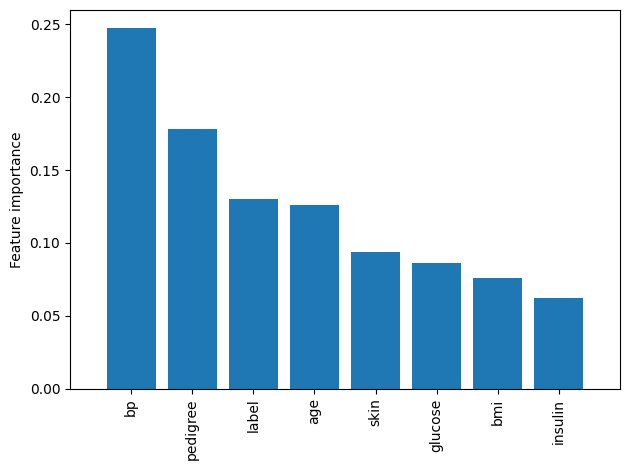

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

plt.ylabel('Feature importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')

feat_labels = df.columns[1:]
plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)

plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()
plt.savefig('feature-importance.pdf', dpi=300)
plt.show()

| Magyar | Angol | Jelentés | Típus |
|---|---|---|---|
| Terhes | Pregnancies | Terhesség ideje (hónapokban) | Szám |
| Vércukor | Glucose | Vércukor 2 órás OGTT vizsgálat után (mg/dL) | Szám |
| Vérnyomás | BloodPressure | Diastolés vérnyomás (Hgmm) | Szám |
| Triceps bőrredő vastagság | SkinThickness | Triceps bőrredő vastagsága (mm) | Szám |
| Testtömeg-index | BMI | Testtömeg-index (kg/m^2) | Szám |
| Családi kórtörténet | DiabetesPedigreeFunction | Családban előforduló cukorbetegség (0=nincs, 1=van) | Kategória |
| Életkor | Age | Életkor (években) | Szám |
| Inzulin | Insulin | 2 órás OGTT vizsgálat során mért inzulin koncentráció (µU/mL) | Szám |
| C-peptid | Cpeptide | 2 órás OGTT vizsgálat során mért C-peptid koncentráció (ng/mL) | Szám |
| Cukorbetegség | Outcome | Cukorbetegség diagnózisa (0=nem, 1=igen) | Kategória |

## Mit tanulhatunk a feature importance-ból?

*  Megmutatja, **mely jellemzők befolyásolják leginkább** a modell döntéseit.
*  Segít a **dimenziócsökkentésben** – a kevésbé fontos változók akár el is hagyhatók.
*  Hasznos **magyarázhatósági eszköz** (explainable AI).
*  A fontosság **adatfüggő** – más tanítóhalmaz esetén az értékek eltérhetnek.

---

## Tipp – Alternatív megközelítések

A scikit-learn alapértelmezett módszere mellett használhatsz:

* **Permutation Importance** (széles körben ajánlott, torzításmentesebb),
* **SHAP values** vagy **LIME** módszereket, amelyek még részletesebb, lokális magyarázatokat adnak.